# Explainable Reinforcement Learning for Longitudinal Control

### Demonstration using the example of the LongiControl Environment

https://www.researchgate.net/publication/349113191_Explainable_Reinforcement_Learning_for_Longitudinal_Control

This notebook demonstrates how to use SHAP for explaining Reinforcement Learning Agents. Here, we are explaining the DDPG actor network from an agent trained on the LongiControl Environment.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from ddpg.DDPG_tf1 import DDPG
import shap
import gym
import warnings
warnings.filterwarnings('ignore') 

### Initialise LongiControl Environment

In [2]:
env = gym.make('gym_longicontrol:StochasticTrack-v0')

### Initialise DDPG

In [3]:
ddpg = DDPG(a_dim=1, s_dim=8, a_bound=1)

### Load trained DDPG agent

In [4]:
best_saver = tf.train.Saver().restore(ddpg.sess,'./checkpoints/model_DDPG_02.ckpt-600')

### DRL Agent – Testing


In [5]:
def eval(mode=0, video=False, speed_limits=[50, 120, 40, 50]):
    action_log = []
    state_log = []    
    if mode==0:
        env = gym.make('gym_longicontrol:StochasticTrack-v0')
    else:
        env = gym.make('gym_longicontrol:DeterministicTrack-v0', speed_limits=speed_limits)
    if video==True:
        env = wrappers.Monitor(env, './videos/' + str(time()) + '/')
    s = env.reset()
    done = False
    reward = 0
    while not(done):
        if video:
            env.render()
        a = ddpg.choose_action(np.array([s]))
        s_, r, done, info = env.step(a)
        s = s_
        reward +=r        
        action_log.append(a)
        state_log.append(s)
   
    return np.array(state_log), np.array(action_log)

Lets the agent drive a random or stochastic track and pass the states and actions

In [6]:
state_log, action_log = eval(mode=1)

### Feature sensitivity

SHAP can be used to investigate the sensitivity of each feature. 

In [7]:
# Build explainer
model = (ddpg.S, ddpg.a) # define inputs and outputs of actor
explainer = shap.DeepExplainer(model, state_log, session=ddpg.sess) # build DeepExplainer
shap_values = explainer.shap_values(state_log) # Calculate shap values

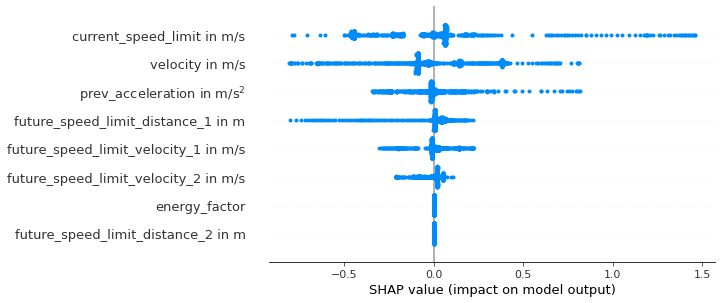

In [8]:
feature_names=['velocity in m/s', 'prev_acceleration in $\mathregular{m/s^2}$', 'current_speed_limit in m/s', 'future_speed_limit_velocity_1 in m/s', 'future_speed_limit_velocity_2 in m/s', 'future_speed_limit_distance_1 in m', 'future_speed_limit_distance_2 in m','energy_factor']

shap.plots._beeswarm.summary_legacy(shap_values[0], feature_names=feature_names, plot_type="dot")

In the example, you can see that the feature 'current_speed_limit' has the greatest influence on the action of the agent.

### RL-SHAP Diagram

The next figure shows the newly introduced RL-SHAP diagram to get an even more comprehensive insight into the decision-making process.

- As additional information the influence of this feature (SHAP value) on the selected action is highlighted with the used colors
- A red coloring of a feature means that this feature increases the value, blue decreases the value and grey means that this value only has a minor influence on the action


In [9]:
def explain(ddpg, state_log, action_log, xlabel, feature_names, state_max_scale=[], state_min_scale=[], feature_mask=[], cmap='coolwarm'):

    # Build explainer
    model = (ddpg.S, ddpg.a) # define inputs and outputs of actor
    explainer = shap.DeepExplainer(model, state_log, session=ddpg.sess) # build DeepExplainer
    shap_values = explainer.shap_values(state_log) # Calculate shap values
       
    if len(state_max_scale)>0:
        state_log = state_log*(state_max_scale - state_min_scale) + state_min_scale # rescale state log  
    norm = plt.Normalize(vmin=-1, vmax=1) # define color scala between -1 and +1 (like the agents action space)  
        
    if len(feature_mask)==0:
        feature_mask = range(state_log.shape[1])

    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(len(feature_mask)+1, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)

    axs[0].scatter(range(0, len(action_log)), action_log, c=action_log-explainer.expected_value, cmap = cmap, norm=norm)
    axs[0].set_ylabel('action')
    for idx, ft_nr in enumerate(feature_mask):
        axs[idx+1].scatter(range(0,len(shap_values[0][:,0])), state_log[:,ft_nr], c=shap_values[0][:,ft_nr], cmap=cmap, norm=norm)
        axs[idx+1].set_ylabel(feature_names[ft_nr])
        if (idx % 2) == 0:
             axs[idx+1].yaxis.set_label_position('right')
    axs[idx+1].set_xlabel(xlabel)
    

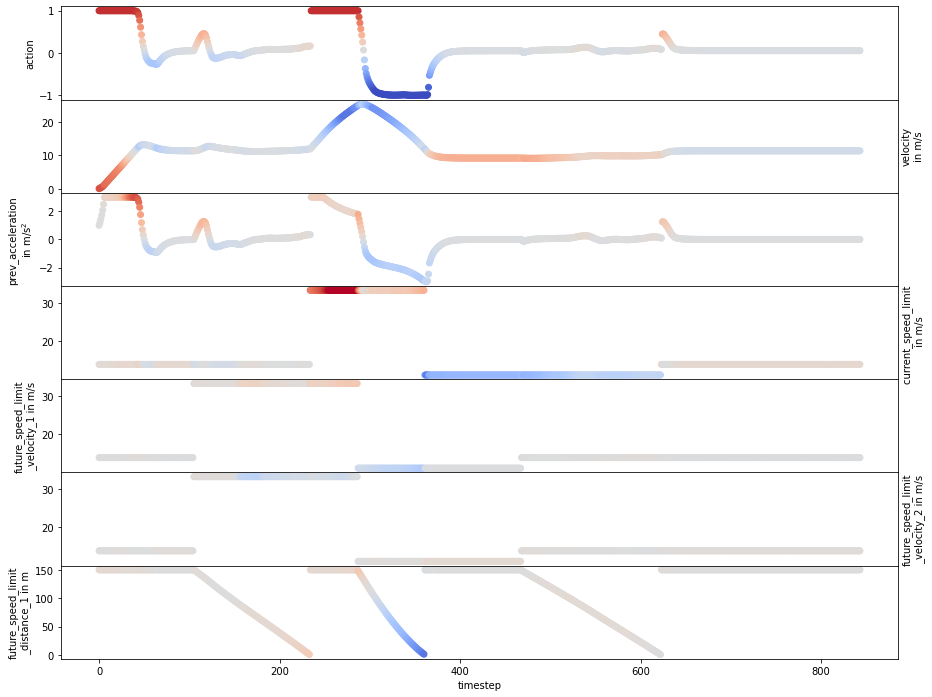

In [10]:
feature_names=['velocity\nin m/s', 'prev_acceleration\nin $\mathregular{m/s^2}$', 'current_speed_limit \n in m/s', 'future_speed_limit\n_velocity_1 in m/s', 'future_speed_limit\n_velocity_2 in m/s', 'future_speed_limit\n_distance_1 in m', 'future_speed_limit\n_distance_2 in m','energy_factor']
feature_mask = np.array([0,1,2,3,4,5])
state_max_scale, state_min_scale = np.array([ 37.,   3.,  37.,  37.,  37., 150., 150.,   5.]), np.array([ 0., -3.,  0.,  0.,  0.,  0.,  0.,  0.])
xlabel = 'timestep'

explain(ddpg=ddpg, state_log=state_log, action_log=action_log, xlabel=xlabel, feature_names=feature_names,state_max_scale=state_max_scale, state_min_scale=state_min_scale, feature_mask=feature_mask)